Sử dụng TensorFlow và Keras để tăng cường dữ liệu và matplotlib để hiển thị các hình ảnh.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.A3M6UR_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

2


 Trích xuất bốn hình ảnh ngẫu nhiên kèm nhãn từ bộ dữ liệu huấn luyện.

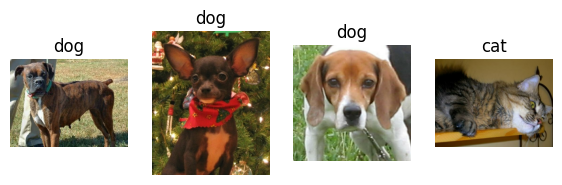

In [ ]:
try:
    get_label_name = metadata.features['label'].int2str
    train_iter = iter(train_ds)
    fig = plt.figure(figsize=(7, 8))
    for x in range(4):
        image, label = next(train_iter)
        fig.add_subplot(1, 4, x + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(get_label_name(label))
except StopIteration:
    print("Dataset iterator is empty!")


#Tăng cường dữ liệu với Keras Sequential
Thông thường, ta sử dụng keras.Sequential() để xây dựng mô hình, nhưng cũng có thể sử dụng nó để thêm các lớp tăng cường dữ liệu.


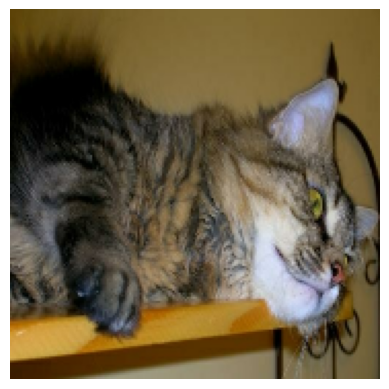

In [ ]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

result = resize_and_rescale(image)
plt.axis('off')
plt.imshow(result);



#Xoay và lật ngẫu nhiên


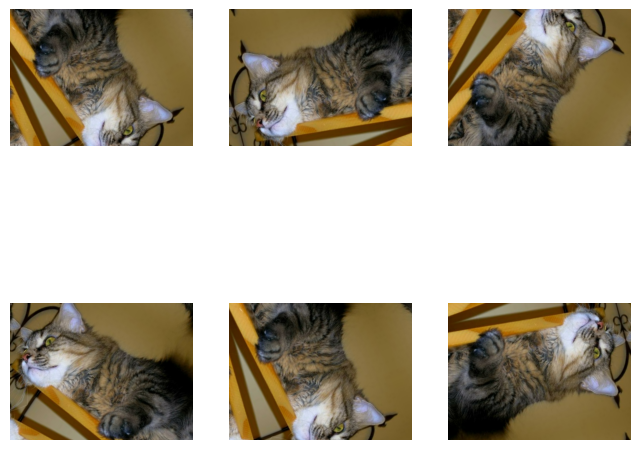

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])


plt.figure(figsize=(8, 7))
for i in range(6):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(augmented_image.numpy()/255)
  plt.axis("off")

#Thêm trực tiếp vào lớp mô hình
Có hai cách để áp dụng tăng cường dữ liệu cho hình ảnh. Cách đầu tiên là thêm trực tiếp các lớp tăng cường vào mô hình.

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1,activation='sigmoid')
])



#Áp dụng hàm tăng cường dữ liệu bằng .map
Cách thứ hai là áp dụng tăng cường dữ liệu cho toàn bộ bộ dữ liệu huấn luyện bằng cách sử dụng `Dataset.map`.

In [ ]:
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

#Tiền xử lý dữ liệu
Tạo một hàm tiền xử lý dữ liệu để xử lý các bộ dữ liệu huấn luyện, kiểm tra và thử nghiệm.  

#Hàm sẽ thực hiện các bước sau:

1. Áp dụng thay đổi kích thước và chuẩn hóa cho toàn bộ bộ dữ liệu.
2. Nếu `shuffle` là True, nó sẽ xáo trộn bộ dữ liệu.
3. Chuyển dữ liệu thành các batch với kích thước batch là 32.
4. Nếu `augment` là True, nó sẽ áp dụng hàm tăng cường dữ liệu cho tất cả các bộ dữ liệu.
5. Cuối cùng, sử dụng `Dataset.prefetch` để chồng lấp quá trình huấn luyện mô hình trên GPU với việc xử lý dữ liệu.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Only apply data augmentation to the training dataset
  if augment:
    # Recreate data_augmentation to adapt to the input shape
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.4),
    ])
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching for all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

#Xây dựng mô hình


In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(180,180,3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1,activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Huấn luyện và đánh giá  
Bộ tối ưu là Adam, hàm mất mát là Binary Cross Entropy, và chỉ số đánh giá là accuracy.


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


582/582 ━━━━━━━━━━━━━━━━━━━━ 649s 1s/step - accuracy: 0.4905 - loss: 1.1571 - val_accuracy: 0.5185 - val_loss: 0.6932


In [ ]:
loss, acc = model.evaluate(test_ds)

73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 328ms/step - accuracy: 0.4831 - loss: 0.6931
